## GBC Model Development

### Libraries

In [116]:
import polars as pl
import pandas as pd
import numpy as np
import os
import sys
import time
import random
import itertools
import json
import pickle
import joblib

import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.colors import ListedColormap

# from sklearn import datasets, metrics, linear_model, svm
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    # RandomizedSearchCV,
    GridSearchCV,
    # KFold,
)
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
# from sklearn.datasets import (
#     make_moons,
#     make_circles,
#     make_classification,
#     make_blobs,
#     make_checkerboard,
# # )
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cluster import KMeans
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    # RandomForestClassifier,
    # AdaBoostClassifier,
    # BaggingClassifier,
    # ExtraTreesClassifier as et,
    GradientBoostingClassifier
)
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    f1_score, matthews_corrcoef, brier_score_loss
)

import shap
# import xgboost as xgb
# import lightgbm
# from imblearn.over_sampling import SMOTE
# import miceforest as mf

# import pycaret
# from pycaret.classification import *

# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn

# Torch CUDA availability flag
# if torch.cuda.is_available():
#     is_cuda = True
import warnings
%matplotlib inline

### Set Seeds

In [117]:
def set_seeds(seed: int = 42):
    """
    Set seeds for Python, NumPy, and environment-level hashing to ensure 
    reproducibility across data loading, CV splits, and model training.

    Parameters
    ----------
    seed : int
        Random seed to apply globally.
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seeds(42)

### Data Prep

#### Choosing ABP or PPG

In [118]:
# Pick Feature Set to use
FeatureChoice = "ABP" # Either "ABP" or "PPG"
FeatureChoice = "PPG"

if FeatureChoice == "ABP":
    featuresFile = 'ABP_FEATURE_LIBRARY_MLORD_DATASET.csv'
    outcomesFile = 'Feature_ABP_Outcomes.csv'
    param_grid = {
        "loss": ["log_loss"],
        "learning_rate": [0.01, 0.03, 0.1],
        "max_depth": [2, 3],            # shallower
        "min_samples_split": [4, 8, 12], 
        "min_samples_leaf": [2, 4],     # prevent tiny leaves
        "n_estimators": [50, 100, 150], # fewer trees needed
        "max_features": ["sqrt", "log2"], # no None → reduces variance
        "subsample": [0.7, 0.85, 1.0],
    }
elif FeatureChoice == 'PPG':
    featuresFile = 'PPG_FEATURE_LIBRARY_MLORD_DATASET.csv'
    outcomesFile = 'Feature_PPG_Outcomes.csv'
    param_grid = {
        "loss": ["log_loss"],
        "learning_rate": [0.01, 0.03, 0.1],
        "max_depth": [2, 3, 4],          # deeper allowed
        "min_samples_split": [2, 4, 8],
        "min_samples_leaf": [1, 2, 4],
        "n_estimators": [100, 200, 300], # more trees for larger dataset
        "max_features": ["sqrt", "log2", None],
        "subsample": [0.7, 0.85, 1.0],
    }

else:
    raise SystemExit("Choose either ABP or PPG")

### Unite and normalize the data

In [119]:

# Using Polars
# read in data
X = pl.read_csv(featuresFile)
temp_outcomes = pl.read_csv(outcomesFile).rename({"StudyID": "Study_ID"})

# ensure consistent type
X = X.with_columns(pl.col("Study_ID").cast(pl.Int64))
temp_outcomes = temp_outcomes.with_columns(pl.col("Study_ID").cast(pl.Int64))

# perform join
X = X.join(
    temp_outcomes.select(["Study_ID", "POMC"]),
    on="Study_ID",
    how="left"
)

# Print some quick debug info
# Unique Study_IDs in features, outcomes, and rows that have matched POMC value (non-null POMC)
print("Unique Study_IDs in features:", X.select(pl.col("Study_ID").n_unique()).item())
print("Unique StudyID in outcomes:", temp_outcomes.select(pl.col("Study_ID").n_unique()).item())
print("Rows matched:", X.select(pl.col("POMC").is_not_null().sum()).item())

# Handle "sex" data so only male and female. The majority will inherit the unknowns (ABP 1 unknown, PPG 2 unknowns)
# Ensure UTF-8
X = X.with_columns(
    pl.col("sex").cast(pl.Utf8)
)

# Normalize text (lowercase + strip)
X = X.with_columns(
    pl.col("sex")
        .str.to_lowercase()
        .str.strip_chars()
        .alias("sex")
)
# Print out the sex column data
# print(X["sex"].unique())
print(X.select(
    pl.col("sex").value_counts()
))
# Set unknowns to the majority sex
majority_sex = (X.filter(pl.col("sex") != "unknown").get_column("sex").mode())[0]
print(f'Majority sex={majority_sex}')
X = X.with_columns(
    pl.when(pl.col("sex") == "unknown")
      .then(pl.lit(majority_sex))
      .otherwise(pl.col("sex"))
      .alias("sex")
)

# Convert "sex" to binary: male = 1, female = 0
X = X.with_columns(
    (pl.col("sex") == "male").cast(pl.Int8).alias("sex")
)
# Reprint the sex column data after uknown conversion to majority
print(X.select(
    pl.col("sex").value_counts()
))

# Print column count and columns
print(f'Columns count: {len(X.columns)} \n{X.columns}')

# Labels (numpy format)
y_np = X["POMC"].to_numpy()

# Features (numpy format)
X_np = X.drop(["POMC", "Study_ID"]).to_numpy()


# Delete unnecessary variables
del temp_outcomes, majority_sex, featuresFile, outcomesFile
# del FeatureChoice
# del X



Unique Study_IDs in features: 16672
Unique StudyID in outcomes: 16672
Rows matched: 16672
shape: (3, 1)
┌─────────────────┐
│ sex             │
│ ---             │
│ struct[2]       │
╞═════════════════╡
│ {"female",8085} │
│ {"male",8585}   │
│ {"unknown",2}   │
└─────────────────┘
Majority sex=male
shape: (2, 1)
┌───────────┐
│ sex       │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {0,8085}  │
│ {1,8587}  │
└───────────┘
Columns count: 847 
['Study_ID', 'pkfrq', 'pkamp', 'PPG_Slope_SYSPO_SYSPP', 'PPG_Slope_SYSPP_DIAN', 'PPG_Slope_DIAN_DIAPP', 'PPG_Slope_DIAPP_DIAPE', 'PPG_AM_FD_Upeak_wrtzero', 'PPG_AM_FD_Vpeak_wrtzero', 'PPG_AM_FD_Wpeak_wrtzero', 'PPG_AM_FD_Upeak_wrtVpeak', 'PPG_AM_FD_Upeak_wrtWpeak', 'PPG_AM_FD_Vpeak_wrtWpeak', 'PPG_AM_RT_FD_Vpeak_wrtzero_PPG_AM_FD_Upeak_wrtzero', 'PPG_AM_RT_FD_Wpeak_wrtzero_PPG_AM_FD_Upeak_wrtzero', 'PPG_AM_RT_FD_Upeak_wrtVpeak_PPG_AM_FD_Upeak_wrtzero', 'PPG_AM_RT_FD_Upeak_wrtWpeak_PPG_AM_FD_Upeak_wrtzero', 'PPG_AM_RT_FD_Vpeak_wrtWpeak_PPG_AM_FD_U

### Describing the data

### Generate train/val/test splits 70/10/20

In [120]:
# ---------------------------------------------------
#   X_np           → numpy array of features
#   y_np           → numpy array of binary POMC labels
# ---------------------------------------------------

# Generate a basic index of the features
indices = np.arange(len(X_np))

# -----------------------------
# 1) Stratified 70% Train, 30% Temp
# -----------------------------
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.30,        # 70/30 split  
    stratify=y_np, 
    random_state=42
)

# -----------------------------
# 2) Split Temp → 10% Val, 20% Test
#  - Temp is 30% of total
#  - To get 10%:20%, we need a 1:2 ratio
#  - test_size=2/3 produces 20% out of full dataset
# -----------------------------
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=2/3,          # 20% test (2/3 of 30%), 10% validation (1/3 of 30%)
    stratify=y_np[temp_idx],
    random_state=42
)

X_train = X_np[train_idx]
y_train = y_np[train_idx]

X_val = X_np[val_idx]
y_val = y_np[val_idx]

X_test = X_np[test_idx]
y_test = y_np[test_idx]



#### Check no row is used in more than one split

In [121]:
# Print the indices
# print(train_idx)
# print(test_idx)
# print(val_idx)

# Convert lists to sets for efficient intersection
set1 = set(train_idx)
set2 = set(test_idx)
set3 = set(val_idx)

# Find common elements between pairs
common_12 = set1.intersection(set2)
common_13 = set1.intersection(set3)
common_23 = set2.intersection(set3)

# Combine all commons
common_in_more_than_one = common_12.union(common_13).union(common_23)

if common_in_more_than_one:
    print("Data exists in more than one list:", common_in_more_than_one)
else:
    print("No data exists in more than one list.")

del set1, set2, set3, common_12, common_13, common_23, common_in_more_than_one

No data exists in more than one list.


### Display the breakdowns of the splits

In [122]:
def summarize_split(name, X, y):
    print(f"\n===== {name.upper()} SPLIT =====")
    print(f"Total samples: {len(X)}")

    # --- POMC distribution ---
    pomc_vals, pomc_counts = np.unique(y, return_counts=True)
    pomc_dict = dict(zip(pomc_vals, pomc_counts))

    neg = pomc_dict.get(0, 0)
    pos = pomc_dict.get(1, 0)

    print("\nPOMC Distribution:")
    print(f"  Negative (0): {neg}  ({neg/len(X):.2%})")
    print(f"  Positive (1): {pos}  ({pos/len(X):.2%})")

    print()


print(f'Splits: Train = {len(X_train)/len(X_np):.0%}; Val = {len(X_val)/len(X_np):.0%}; Test = {len(X_test)/len(X_np):.0%}')
summarize_split("Train", X_train, y_train)
summarize_split("Validation", X_val, y_val)
summarize_split("Test", X_test, y_test)

Splits: Train = 70%; Val = 10%; Test = 20%

===== TRAIN SPLIT =====
Total samples: 11670

POMC Distribution:
  Negative (0): 10196  (87.37%)
  Positive (1): 1474  (12.63%)


===== VALIDATION SPLIT =====
Total samples: 1667

POMC Distribution:
  Negative (0): 1456  (87.34%)
  Positive (1): 211  (12.66%)


===== TEST SPLIT =====
Total samples: 3335

POMC Distribution:
  Negative (0): 2914  (87.38%)
  Positive (1): 421  (12.62%)



### Impute missing values

In [123]:
# Impute missing values. Fit on the training data then apply to all splits
# create imputer
imputer = SimpleImputer(strategy="mean")

# fit ONLY on training data
imputer.fit(X_train)

# transform all splits
X_train = imputer.transform(X_train)
X_val   = imputer.transform(X_val)
X_test  = imputer.transform(X_test)

In [124]:
# Check the imputed model filled in all NaNs and didn't change the shape
print("Train NaNs:", np.isnan(X_train).sum())
print("Val NaNs:",   np.isnan(X_val).sum())
print("Test NaNs:",  np.isnan(X_test).sum())
print("Train shape:", X_train.shape)
print("Val shape:",   X_val.shape)
print("Test shape:",  X_test.shape)
# print(pd.DataFrame(X_train).describe().T)
print(f'Columns that became constant: {np.where(np.all(X_train == X_train[0], axis=0))[0]}')
# print("Original NaNs per column:", np.isnan(X_np).sum(axis=0))
print("Original NaNs total:", np.sum(np.isnan(X_np).sum(axis=0)))

Train NaNs: 0
Val NaNs: 0
Test NaNs: 0
Train shape: (11670, 845)
Val shape: (1667, 845)
Test shape: (3335, 845)
Columns that became constant: []
Original NaNs total: 0


## GBC Time

In [125]:
def train_gbc(
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    param_grid,
    random_state=42
):
    """
    Train a GradientBoostingClassifier (GBC) with hyperparameter tuning using
    stratified cross-validation, optimizing for both Average Precision (AP) and ROC AUC.

    The final estimator is refit using AP, but summary metrics for both AP-optimized and AUC-optimized models
    are returned. Also returns validation and test set metrics, as well as subgroup-ready copies 
    of the test data.

    Returns:
        best_model : sklearn.ensemble.GradientBoostingClassifier
            The final estimator refit on AP-selected hyperparameters.
        results : dict
            Dictionary summarizing model parameters, CV/train/validation/test metrics,
            full CV results, and subgroup-ready test data. Keys include:
                - 'cv_best_params_by_ap': Best params when optimizing AP in CV.
                - 'cv_best_params_by_auc': Best params when optimizing ROC AUC in CV.
                - 'cv_mean_ap', 'cv_std_ap': Mean and std of AP from CV test folds (AP-selected model).
                - 'cv_mean_ap_train', 'cv_std_ap_train': Mean and std AP on CV training folds.
                - 'cv_mean_auc', 'cv_std_auc': Mean and std ROC AUC from CV test folds (AUC-selected model).
                - 'cv_mean_auc_train', 'cv_std_auc_train': Mean and std ROC AUC on CV training folds.
                - 'val_ap', 'val_auc': AP and ROC AUC on validation set.
                - 'test_ap', 'test_auc': AP and ROC AUC on test set.
                - 'X_test', 'y_test': Test data.
                - 'cv_res': Full cross-validation results DataFrame.
                - 'test_pred_bin': Binary predictions on test set.
        test_pred : np.ndarray
            Probability predictions for the test set.

    Notes:
        - AP refers to 'average precision', a metric for ordinal or binary classification.
        - ROC AUC refers to receiver operating characteristic area-under-curve.
        - This function supports subgroup testing by returning test data copies.
        - For confusion metrics, use 'test_pred_bin'.
    """

    # ------------------------------
    # Base model
    # ------------------------------
    model = GradientBoostingClassifier(random_state=random_state)

    # Stratified CV object
    skf = StratifiedKFold(
        n_splits=4,
        shuffle=True,
        random_state=random_state
    )

    # ------------------------------
    # Grid Search
    # ------------------------------
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=["roc_auc", "average_precision"],
        refit="average_precision",     # final model optimized on AP
        cv=skf.split(X_train, y_train),
        return_train_score=True,
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X_train, y_train)


    # ------------------------------
    # Extract CV results as DataFrame
    # ------------------------------
    cv_res = pd.DataFrame(grid.cv_results_)

    # Identify best params under each metric
    best_by_ap = cv_res.loc[
        cv_res["rank_test_average_precision"] == 1
    ].iloc[0]

    best_by_auc = cv_res.loc[
        cv_res["rank_test_roc_auc"] == 1
    ].iloc[0]

    best_model = grid.best_estimator_

    # ------------------------------
    # Extract mean/std for AP-selected model
    # ------------------------------
    cv_mean_ap = best_by_ap["mean_test_average_precision"]
    cv_std_ap  = best_by_ap["std_test_average_precision"]

    # ------------------------------
    # Extract mean/std for AUC-selected model
    # ------------------------------
    cv_mean_auc = best_by_auc["mean_test_roc_auc"]
    cv_std_auc  = best_by_auc["std_test_roc_auc"]

    # ------------------------------
    # Optional: train metrics for diagnostics
    # ------------------------------
    cv_mean_ap_train  = best_by_ap.get("mean_train_average_precision", None)
    cv_std_ap_train   = best_by_ap.get("std_train_average_precision", None)

    cv_mean_auc_train = best_by_auc.get("mean_train_roc_auc", None)
    cv_std_auc_train  = best_by_auc.get("std_train_roc_auc", None)

    # ------------------------------
    # Validation predictions
    # ------------------------------
    val_pred = best_model.predict_proba(X_val)[:, -1]
    val_auc = roc_auc_score(y_val, val_pred)
    val_ap  = average_precision_score(y_val, val_pred)

    # ------------------------------
    # Test predictions
    # ------------------------------
    test_pred = best_model.predict_proba(X_test)[:, -1]
    test_auc = roc_auc_score(y_test, test_pred)
    test_ap  = average_precision_score(y_test, test_pred)

    # Binary predictions (useful for confusion metrics)
    test_pred_bin = (test_pred >= 0.5).astype(int)

    # Confusion Matrix
    confuse_matrix = confusion_matrix(y_test, test_pred_bin)
    tn, fp, fn, tp = confuse_matrix.ravel()

    # Basic Metrics
    f1 = f1_score(y_test, test_pred_bin)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    fnr = fn / (tp + fn) if (tp + fn) > 0 else np.nan
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan

    # Breir Score, MCC
    brier = brier_score_loss(y_test, test_pred)      
    
    mcc = matthews_corrcoef(y_test, test_pred_bin)

    # Shapley
    explainer = shap.Explainer(best_model, X_train)
    shap_values = explainer(X_test)

    # ------------------------------
    # Bundle everything
    # ------------------------------
    results = {
        # CV best params
        "cv_best_params_by_ap":  best_by_ap["params"],
        "cv_best_params_by_auc": best_by_auc["params"],

        # CV means/std
        "cv_mean_ap":  cv_mean_ap,
        "cv_std_ap":   cv_std_ap,
        "cv_mean_auc": cv_mean_auc,
        "cv_std_auc":  cv_std_auc,

        # Optional train metrics
        "cv_mean_ap_train":  cv_mean_ap_train,
        "cv_std_ap_train":   cv_std_ap_train,
        "cv_mean_auc_train": cv_mean_auc_train,
        "cv_std_auc_train":  cv_std_auc_train,

        # Validation metrics
        "val_auc": val_auc,
        "val_ap":  val_ap,

        # Test metrics
        "test_auc": test_auc,
        "test_ap":  test_ap,

        # Test data copies for subgroup analysis
        "X_test": X_test,
        "y_test": y_test,

        # Full CV results (for plotting/inspection)
        "cv_res": cv_res,

        # Also store the binary predictions and other metrics
        "test_pred_bin": test_pred_bin,
        "confuse_matrix": confuse_matrix,
        "tp": int(tp),
        "fp": int(fp),
        "tn": int(tn),
        "fn": int(fn),
        "f1": round(f1, 4),
        "fpr": round(fpr, 4),
        "fnr": round(fnr, 4),
        "ppv": round(ppv, 4),
        "npv": round(npv, 4),
        "accuracy": round(accuracy, 4),
        "specificity": round(specificity, 4),
        "sensitivity": round(sensitivity, 4),
        "brier_score": round(brier, 4),
        "mcc": round(mcc, 4),
        "shap_values": shap_values.values,
        "shap_base": shap_values.base_values,

    }

    return best_model, results, test_pred


In [126]:
def summarize_gbc(best_model, results):
    """
    Pretty-print dual-metric cross-validation summary, including:
      - CV mean/std for AP-selected model
      - CV mean/std for AUC-selected model
      - Validation and held-out test performance
      - Baseline AP (positive prevalence)
    """
    print(f"\n == {FeatureChoice} Results == ")
    print("\n===== CROSS-VALIDATION SUMMARY =====")

    # ------------------------
    # Baseline AP (positive prevalence)
    # ------------------------
    baseline_ap = results["y_test"].mean()
    print(f"\nBaseline AP (positive prevalence): {baseline_ap:.4f}")

    # ------------------------
    # Best params by AP
    # ------------------------
    print("\n----- Best Params Selected by Average Precision (AP) -----")
    print(results["cv_best_params_by_ap"])

    print("\nCV Performance (AP-selected model):")
    print(f"  AP  mean ± std : {results['cv_mean_ap']:.4f} ± {results['cv_std_ap']:.4f}")

    # ------------------------
    # Optional train metrics
    # ------------------------
    if results.get("cv_mean_ap_train") is not None:
        print("\n  Train-set diagnostics (AP-selected model):")
        print(f"    AP  mean ± std : {results['cv_mean_ap_train']:.4f} ± {results['cv_std_ap_train']:.4f}")

    # ------------------------
    # Best params by AUC
    # ------------------------
    print("\n----- Best Params Selected by ROC-AUC -----")
    print(results["cv_best_params_by_auc"])

    print("\nCV Performance (AUC-selected model):")
    print(f"  AUC mean ± std : {results['cv_mean_auc']:.4f} ± {results['cv_std_auc']:.4f}")

    if results.get("cv_mean_auc_train") is not None:
        print("\n  Train-set diagnostics (AUC-selected model):")
        print(f"    AUC mean ± std : {results['cv_mean_auc_train']:.4f} ± {results['cv_std_auc_train']:.4f}")

    # ------------------------
    # Validation
    # ------------------------
    print("\n===== VALIDATION PERFORMANCE =====")
    print(f"Validation ROC-AUC : {results['val_auc']:.4f}")
    print(f"Validation AP      : {results['val_ap']:.4f}")

    # ------------------------
    # Test
    # ------------------------
    print("\n===== TEST PERFORMANCE (HELD-OUT) =====")
    print(f"Test ROC-AUC : {results['test_auc']:.4f}")
    print(f"Test AP      : {results['test_ap']:.4f}  (baseline {baseline_ap:.4f})")

    # Confusion Matrix
    if results.get('test_pred_bin') is not None:
        print("\n===== COUNTS and CONFUSION MATRIX =====")
        print("Test binary predictions (class counts):\n(number of test samples predicted as 0 (negative) and 1 (positive) by the classifier's threshold.)")
        print(np.bincount(results['test_pred_bin']))
        # cm = confusion_matrix(y_test, results['test_pred_bin'])
        # print(cm)
        # tn, fp, fn, tp = results['confuse_matrix'].ravel()
        print("\nConfusion Matrix (labels: actual rows, predicted columns):")
        print(f"            Pred 0   Pred 1")
        print(f"Actual 0 |  {results['tn']}   {results['fp']}   |  TN  FP")
        print(f"Actual 1 |  {results['fn']}   {results['tp']}   |  FN  TP\n")
        print(f"F1 Score: {results['f1']}")
        print(f"Accuracy: {results['accuracy']}")
        print(f"Sensitivity: {results['sensitivity']}")
        print(f"Specificity: {results['specificity']}")
        print(f"Positive Predicted Value (PPV): {results['ppv']}")
        print(f"Negative Predicted Value (NPV): {results['npv']}")
        print(f"False Positive Rate (FPR): {results['fpr']}")
        print(f"False Negative Rate (FNR): {results['fnr']}")
    print()

    print(f"Matthews CC: {results['mcc']}")
    print(f"Brier Score: {results['brier_score']}")

    # SHAP Feature Impact
    print("\nFeature impact (SHAP):")
    print("See SHAP summary plot for most influential features.")
    with warnings.catch_warnings():   # DOING this to surpress the numpy random see future warning
        warnings.simplefilter("ignore", category=FutureWarning)
        shap.summary_plot(results['shap_values'], X_test)


### Run model

In [109]:
best_model, results, test_pred = train_gbc(
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    param_grid, random_state=42
)


#### Summarize results


 == ABP Results == 

===== CROSS-VALIDATION SUMMARY =====

Baseline AP (positive prevalence): 0.2859

----- Best Params Selected by Average Precision (AP) -----
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100, 'subsample': 0.85}

CV Performance (AP-selected model):
  AP  mean ± std : 0.5693 ± 0.0188

  Train-set diagnostics (AP-selected model):
    AP  mean ± std : 0.8714 ± 0.0024

----- Best Params Selected by ROC-AUC -----
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100, 'subsample': 1.0}

CV Performance (AUC-selected model):
  AUC mean ± std : 0.7596 ± 0.0079

  Train-set diagnostics (AUC-selected model):
    AUC mean ± std : 0.8638 ± 0.0015

===== VALIDATION PERFORMANCE =====
Validation ROC-AUC : 0.7569
Validation AP      : 0.5734

===== TEST PERFORMANCE (HELD-OUT) =====
Test ROC-

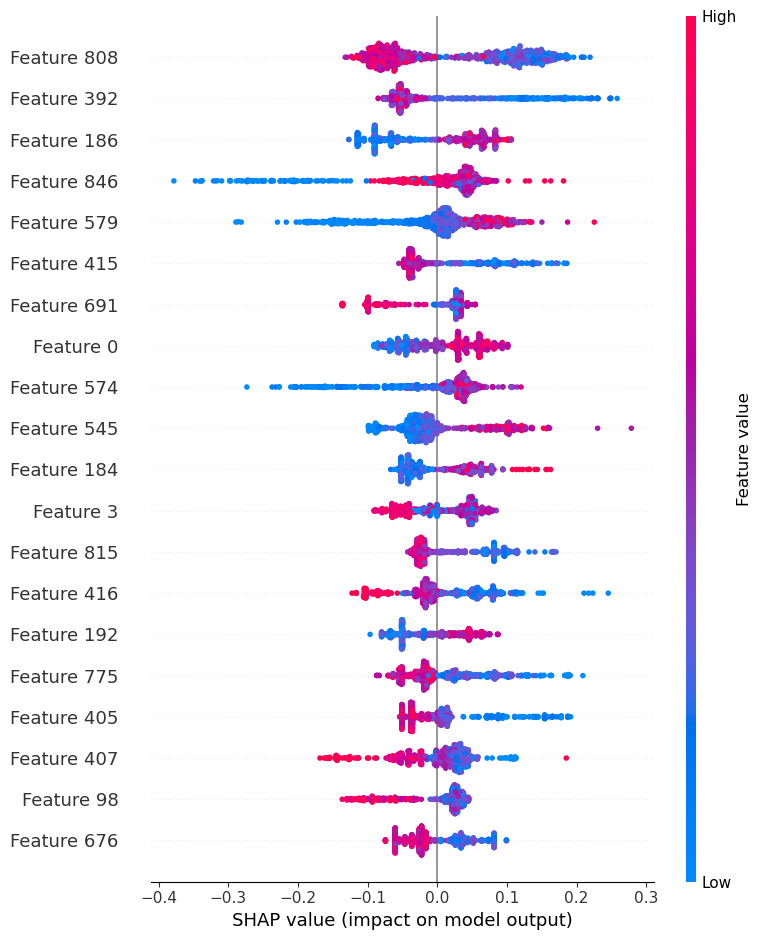

In [110]:
summarize_gbc(best_model, results)


### Saving outputs to file

In [ ]:
import json
import numpy as np

def prepare_for_json(d):
    result_json = {}
    for k, v in d.items():
        if isinstance(v, np.ndarray):
            result_json[k] = v.tolist()
        elif isinstance(v, pd.DataFrame):
            result_json[k] = v.to_dict(orient="records")
        else:
            result_json[k] = v
    return result_json

# Prepare
json_ready_results = prepare_for_json(results)

with open(f"outputs/gbc_{FeatureChoice}_model_results.json", "w") as f:
    json.dump(json_ready_results, f, indent=4)


# Save cv_res separately as CSV if preferred
if 'cv_res' in results:
    results['cv_res'].to_csv(f"outputs/gbc_{FeatureChoice}_cv_res.csv", index=False)


In [113]:
import pandas as pd

summary_metrics = {k: v for k, v in results.items() if isinstance(v, (int, float, str))}
pd.DataFrame([summary_metrics]).to_csv(f"outputs/gbc_{FeatureChoice}_model_summary.csv", index=False)


In [ ]:
import io
from contextlib import redirect_stdout

f = io.StringIO()
with redirect_stdout(f):
    summarize_gbc(best_model, results)
summary_text = f.getvalue()

with open(f"outputs/gbc_{FeatureChoice}_model_summary.txt", "w") as text_file:
    text_file.write(summary_text)


In [115]:
import matplotlib.pyplot as plt
shap.summary_plot(results['shap_values'], X_test, show=False)
plt.savefig(f"outputs/gbc_{FeatureChoice}_shap_summary_plot.png")
plt.close()


/tmp/ipykernel_3840054/3347745227.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(results['shap_values'], X_test, show=False)


### DONE

# GBC - SAMPLE NOTEBOOK

In [ ]:
set_seeds(42)
model = gbc()
parameter_space = {
    'loss':['log_loss','deviance','exponential'],
    'learning_rate':[0.01,0.1,1],
    'n_estimators':[100,200],
    'criterion':['friedman_mse','mse','squared_error'],
    'min_samples_split':[1,2,3],
    'min_samples_leaf':[1,2],
    'max_depth':[2,3,4],
    'max_features':['auto','sqrt','log2'],


}

folds = 4

skf = StratifiedKFold(n_splits=folds, shuffle = True)

              
random_search = GridSearchCV(model, parameter_space, scoring=['roc_auc','average_precision'],verbose=2, return_train_score=True, cv=skf.split(X_train,y_train),refit=False)

# Here we go
#start_time = timer(None) # timing starts from this point for "start_time" variable

random_search.fit(X_train, y_train)
#timer(start_time) # timing ends here for "start_time" variable

#print(random_search.best_estimator_)
#print(random_search.best_score_)
df=pd.DataFrame(random_search.cv_results_)
df[df["rank_test_roc_auc"]==1][["params","mean_test_roc_auc","std_test_roc_auc","mean_test_average_precision","std_test_average_precision"]]

In [ ]:
df=pd.DataFrame(random_search.cv_results_)
df[df["rank_test_roc_auc"]==1][["params","mean_test_roc_auc","std_test_roc_auc","mean_test_average_precision","std_test_average_precision"]]

In [ ]:
df[df["rank_test_roc_auc"]==1]["params"][df[df["rank_test_roc_auc"]==1]["params"].index[0]]